# Initial Setup

## 1. Reading clinical trials & Patient cases

In [31]:
%reload_ext autoreload
%autoreload 2

import pprint
import loader as ld
from loadtrials import load_trials, load_queries, get_evaluator, LONG_QUERIES


pp = pprint.PrettyPrinter(width=120, compact=True)

cases      = load_queries()
long_cases = load_queries(LONG_QUERIES)
eval  = get_evaluator(cases)

ids, full_docs = ld.load(
    'docs',
    lambda: load_trials(eval)
)

## 2. Build the corposes

In [32]:
# setting up the corpus
import index

corpus = {
    'bief_title': [],
    'brief_summary': [],
    'detailed_description': [],
    'criteria': []
}

for trial in full_docs:
    corpus['bief_title'].append(trial._brief_title)
    corpus['brief_summary'].append(trial._brief_summary)
    corpus['detailed_description'].append(trial._detailed_description)
    corpus['criteria'].append(trial._criteria)


## 3. Setting filtering methods

In [33]:
import re
import numpy as np  

# MIN_SCORE = -10 ** 6

# TODO: define a class query where this are defined as variables of each query
age_re    = re.compile(r'(\d+)\s?(-?(year|month)(-|\s)old|yo)')
young_re  = re.compile(r'young\s(adult\s)?(man|woman|men|women)', re.IGNORECASE)
adult_re  = re.compile(r'man|woman|men|women', re.IGNORECASE)
gender_re = re.compile(r'\b(male|female|man|his|her|woman|boy|girl|men|women)\b', re.IGNORECASE)

male_expression = ['male', 'man', 'boy', 'men', 'his']


MIN_VALUE = - 10 ** 6

def get_age(case):
    res = age_re.search(case)

    if res is None:
        # taken from: https://www.quora.com/At-what-age-does-a-female-turn-from-a-girl-to-a-lady-and-then-finally-a-woman
        # which is probably not the most trustable source ...
        case = case.lower()
        if young_re.search(case) != None:
            return 18
        if adult_re.search(case) != None:
            return 25
        return 0

    age_or_month = int(res.group(1))
    return age_or_month if res.group(3) != 'month' else age_or_month / 12

def get_gender(case):
    res = gender_re.findall(case)
    if len(res) == 0:
        return 'Both'

    # return res[0] if len(res) > 0 else 'both'
    return 'Male' if res[0].lower() in male_expression else 'Female'


# TODO; complete this function
def filter_by_age_and_gender(doc_scores, query):
    gender = get_gender(query)
    age    = get_age(query)

    # min_score = np.min(doc_scores) - 1
    for i in range(len(doc_scores)):
        doc_gender   = full_docs[i]._gender
        doc_max_age  = full_docs[i]._maximum_age
        doc_min_age  = full_docs[i]._minimum_age 
        if (doc_gender.lower() == 'both' or doc_gender == gender) \
            and doc_max_age >= age and doc_min_age <= age: continue
        doc_scores[i] = MIN_VALUE

    # TO DO: Implement filters by age and gender
    return doc_scores

# pp.pprint(cases)
# for case in long_cases.values():
#     age = get_age(case)
#     gender = get_gender(case)
#     pp.pprint({
#         'case': case,
#         'take-age': age,
#         'taken-gender': gender
#     })
# pp.pprint(cases)

# full_docs[2729].show()

## 4. Setting some metrics

In [62]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trec

from typing import Dict 

plt.rcParams['figure.figsize'] = [12, 6]

class Metrics:
    # where each row is a tuple of (docid, ap, p10, mrr, ndcg5, recall)
    def __init__(self, rows, precision):#m_ap, p10, mrr, ndcg5, recall):

        self.data = pd.DataFrame(
            rows, 
            columns = ['caseid', 'ap', 'p10', 'mrr', 'ndcg@5', 'recall@100', 'relevant-documents']
        )

        self.data.set_index('caseid', inplace=True)

        # for each query we have a tuple of (precision_11point, recall_11point, total_relv_ret)
        self.precision = precision
        self.recall    = trec.RECALL_11POINT

        res = self.data.mean()#.drop(columns=['caseid']).mean()
        self.m_ap    = res['ap']
        self.m_p10   = res['p10']
        self.m_mrr   = res['mrr']
        self.m_ndcg5 = res['ndcg@5']
        self.m_recall100 = res['recall@100']

        # self.mean_precision_11point = np.sum(list(precision.values())) / len(precision)
        self.mean_precision_11point = np.mean(precision, axis=0) #np.sum(list(precision.values())) / len(precision)

        confidence = 0.99
        std_deviasion = np.std(precision, axis=0)
        mean = self.mean_precision_11point #np.mean(values, axis=0)

        diff = confidence * (std_deviasion / np.sqrt(len(precision)))

        self.upper_precision = mean + diff
        self.lower_precision = mean - diff

    

    def plot_documents_precision(self, model='', filename=None):
        self.data.plot.scatter(
            x='relevant-documents',
            y='p10',
            # colormap='viridis',
        )

        _, top = plt.ylim()
        plt.ylim(0, top)
        plt.title(f'P10/relevant-documents relation by query (for model {model})')
        # plt.savefig(f'{model}-p10-relevant-documents.pdf')
        if filename is not None:
            plt.savefig(filename+ '.pdf')
            
        plt.show()


    def plot_precision_recall(self, model_name, filename=None):

        # values = self.precision

        # # here the axis, is the axis upon which it will iterate
        # confidence = 0.99
        # std_deviasion = np.std(values, axis=0)
        # mean = self.mean_precision_11point #np.mean(values, axis=0)

        # diff = confidence * (std_deviasion / np.sqrt(len(values)))

        plt.plot(self.recall, self.mean_precision_11point)
        plt.title(f'Precision/Recall curve for {model_name}')
        plt.xlabel("Recall", fontweight='bold')
        plt.ylabel("Precision", fontweight='bold')

        _, top = plt.ylim()
        plt.ylim(0, top)

        plt.fill_between(
            self.recall, 
            self.lower_precision,
            self.upper_precision,
            # mean - diff, 
            # mean + diff, 
            alpha=0.2
        )

        if filename is not None:
            plt.savefig(filename+ '.pdf')
        plt.show()

    def plot_top_5p10_metrics(self, model_name, filename=None):
        aux = self.data.sort_values(
            by=['p10'], ascending = False
        ).drop(columns=['relevant-documents'])

        ax  = aux.head(5).plot(
            kind='bar'
        )

        for cnt in ax.containers:
            ax.bar_label(cnt, labels=[f"{round(v, 1)}" for v in cnt.datavalues])

        plt.title(f'Metrics for the first 5 queries ranked by P10 for model {model_name}')
        plt.xticks(rotation=0, horizontalalignment="center")
        plt.xlabel('Case Indentifier', fontweight='bold')

        # plt.savefig(f'{model_name}-top5-metrics.pdf')
        if filename is not None:
            plt.savefig(filename+ '.pdf')
        plt.show()



def compare_pecision_recall_models(metrics, filename=None):

    for model_name, m in metrics.items():
        plt.plot(m.recall, m.mean_precision_11point, label=model_name)

        plt.fill_between(
            m.recall, 
            m.lower_precision,
            m.upper_precision,
            alpha=0.2
        )

    _, top = plt.ylim()
    plt.ylim(0, top)
    plt.xlim(0, 1)
    plt.title(f'Precision/Recall curve for all the Models')
    plt.xlabel("Recall", fontweight='bold')
    plt.ylabel("Precision", fontweight='bold')

    plt.legend(title="Models")

    if filename is not None:
        plt.savefig(filename+ '.pdf')
    plt.show()

def calc_metrics_summary(metrics : Dict[str, Metrics]):

    rows = []
    for model_name, m in metrics.items():
        rows.append((model_name, m.m_ap, m.m_mrr, m.m_p10, m.m_ndcg5, m.m_recall100))

    metrics_summary = pd.DataFrame(
        rows,
        columns = ['model', 'MAP', 'MRR', 'P10', 'NDCG@5', 'Recall@100'],
    )

    metrics_summary.set_index('model', inplace=True)
    return metrics_summary


def plot_summary_metrics(metrics_summary : pd.DataFrame, decimal_case=2, filename=None):
    ax = metrics_summary.plot(
        kind='bar',
        figsize=(30, 8),
        width=0.8
    )

    for cnt in ax.containers:
        ax.bar_label(cnt, labels=[f"{round(v, decimal_case)}" for v in cnt.datavalues], fontsize=12)

    plt.xticks(rotation=0, horizontalalignment="center", fontsize=14)
    plt.xlabel('Models', fontweight='bold', fontdict={'fontsize': 15})
    plt.title('Performance of each one of the models', fontdict={'fontsize': 20})
    # plt.ylim(0, 0.5)
    plt.legend(title='Metrics', fontsize=15, title_fontsize=15)

    if filename is not None:
        plt.savefig(filename + '.pdf')
    plt.show()
    # plt.savefig('models-performance.pdf')

def calc_ranking(index, query, filter=True) -> pd.DataFrame:
    doc_scores = index.search(query)
    if filter:
        doc_scores = filter_by_age_and_gender(doc_scores, query)

    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)

    return results_ord

def calc_metrics(index, queries) -> Metrics:

    # simple metrics rows
    rows      = []
    precision = []#{}

    for caseid, query in queries.items():
        # query = cases[caseid]
        # doc_scores = index.search(query)
        # doc_scores = filter_by_age_and_gender(doc_scores, query)

        # results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        # results_ord = results.sort_values(by=['score'], ascending = False)
        results_ord = calc_ranking(index, query)

        [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        # precision[caseid] = precision_11point #, total_relv_ret)
        precision.append( precision_11point ) #, total_relv_ret)
        

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        # add the precision at 11 points
        rows.append(
            (caseid, ap, p10, mrr, ndcg5, recall, total_relv_ret)
        )

    return Metrics(rows, precision)

# def tes
def get_metrics(index, queries) -> pd.DataFrame:
    # if path.exists('metrics.bin'):
    #     return pickle.load(open('metrics.bin', 'rb'))

    params = {}
    # avg_precision_11point = np.zeros(11)

    metrics_rows = []
    for lbd in np.arange(0, 1, 0.05):
        params['lambda'] = lbd
        index.set_params(params)
        m = calc_metrics(index, queries)
        metrics_rows.append((
            lbd, m.m_ap, m.m_p10, m.m_mrr, 
            m.m_ndcg5, m.m_recall100
        ))

    rows = pd.DataFrame(metrics_rows, columns = ['lambda', 'MAP', 'P10', 'MRR', 'NDCG@5', 'Recall@100'])
    # pickle.dump(rows, open('metrics.bin', 'wb'))
    return rows


def plot_lambdas_metrics(result : pd.DataFrame, title : str, choosen_lambda : float, filename=None):

    for metric in result.columns:
        plt.plot(
            result.index, 
            result[metric], 
            label=metric,
        )

    _, top = plt.ylim()
    plt.ylim(0, top)
    plt.xlim(0, 1)
    plt.axvline(x = choosen_lambda, color = 'red', linestyle = '--', alpha = 0.5)

    plt.title(title)
    plt.legend(title='Metrics')
    plt.xlabel('Lambda values', fontweight='bold')
    plt.xticks(result.index)

    if filename is not None:
        plt.savefig(filename+ '.pdf')
    plt.show()
    # plt.figure(figsize=(100, 20))

    # plt.savefig(f'{title}.pdf')
    # plt.clf()

# Things we can do:
# - We can change the tokenizer
# - And we can change the lambdas

# MRR  => 1 over the first relevant
# NDCG => if documents respect the relevance 
# order (where K is the number of documents we will consider)

# rows.set_index('lambda', inplace=True)
# we've choosen 0.2 as the best lambda
# beause it has the maximum value for P10
# and good values for MAP and NDCG@5, while
# the rest is equals to all the rows

# TODO: test best lambda between 0.15 and 0.25

# 1st Phase

## 1. Building the models

In [5]:
# two models used on the first phase :)
vsm  = index.VSMindex(corpus['bief_title'])
lmjm = index.LMJMindex(corpus['bief_title'])

## 2. Calibrating parameters

### 2.1 Calibrating the lambda using (short queries)

In [226]:
short_rows = get_metrics(lmjm, cases)
short_rows.set_index('lambda', inplace=True)
short_rows

,MAP,P10,MRR,NDCG@5,Recall@100
lambda,,,,,
0.00,0.007448,0.001695,0.028387,0.005748,0.036427
0.05,0.042186,0.057627,0.183455,0.049144,0.201303
0.10,0.042949,0.061017,0.183510,0.054550,0.196103
0.15,0.043679,0.062712,0.184233,0.060218,0.188799
0.20,0.043278,0.062712,0.179719,0.061554,0.190660
0.25,0.043427,0.061017,0.176952,0.061790,0.188845
0.30,0.042803,0.061017,0.175719,0.060679,0.187785
0.35,0.042004,0.059322,0.170624,0.054290,0.181705
0.40,0.041355,0.059322,0.170897,0.055774,0.175702


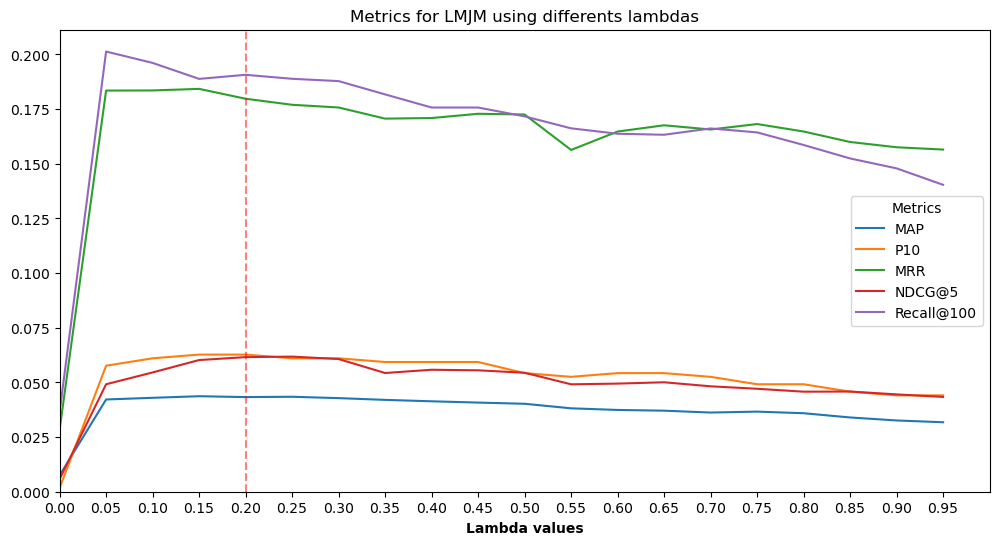

In [264]:
plot_lambdas_metrics(
    short_rows, 
    'Metrics for LMJM using differents lambdas', 
    0.2
)

### 2.2 Calibrating the lambdas using (long queries)

In [261]:
long_rows = get_metrics(lmjm, long_cases)
long_rows.set_index('lambda', inplace=True)
long_rows

LMJM lambda  0.0
LMJM lambda  0.05
LMJM lambda  0.1
LMJM lambda  0.15000000000000002
LMJM lambda  0.2
LMJM lambda  0.25
LMJM lambda  0.30000000000000004
LMJM lambda  0.35000000000000003
LMJM lambda  0.4
LMJM lambda  0.45
LMJM lambda  0.5
LMJM lambda  0.55
LMJM lambda  0.6000000000000001
LMJM lambda  0.65
LMJM lambda  0.7000000000000001
LMJM lambda  0.75
LMJM lambda  0.8
LMJM lambda  0.8500000000000001
LMJM lambda  0.9
LMJM lambda  0.9500000000000001


,MAP,P10,MRR,NDCG@5,Recall@100
lambda,,,,,
0.00,0.007448,0.001695,0.028387,0.005748,0.036427
0.05,0.030655,0.038983,0.150398,0.038228,0.155433
0.10,0.028597,0.032203,0.133354,0.032162,0.150452
0.15,0.026682,0.023729,0.126727,0.027676,0.149977
0.20,0.025557,0.020339,0.121144,0.027424,0.147082
0.25,0.024805,0.023729,0.120234,0.027676,0.143169
0.30,0.024022,0.023729,0.115628,0.027047,0.132034
0.35,0.023253,0.025424,0.111408,0.024498,0.129431
0.40,0.022609,0.027119,0.110688,0.024372,0.128121


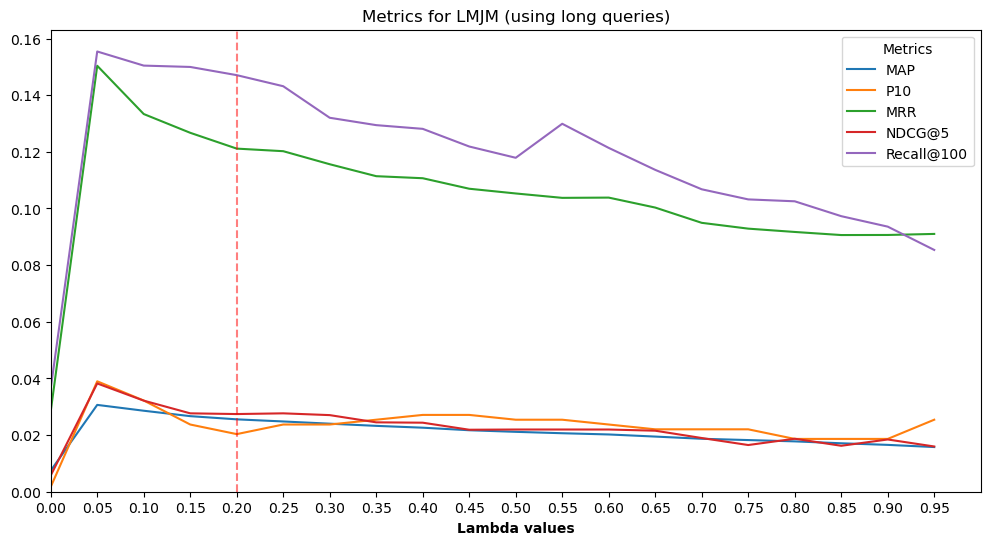

In [265]:
plot_lambdas_metrics(
    long_rows, 
    'Metrics for LMJM (using long queries)', 
    0.2
)

## 3. Evaluation

In [6]:
import pprint as pp

# our models
models = {
    'TF-IDF Vector Space Model': vsm, 
    'LMJM Model': lmjm
}

# seeting up parameters
lmjm.set_params({'lambda': 0.2}) 

# sub = {}
# for cid, query in list(cases.items())[:5]:
#     sub[cid] = query

# calculating metrics
models_metrics = {}
for model_name, letor_model in models.items():
    models_metrics[model_name] = calc_metrics(letor_model, cases)

# Charts I can do:
#    x query/relevant documents
#    X table
#    - a sort of histogram for a certain number of queries
#    - precision/recall curve


LMJM lambda  0.2


In [7]:
# [(model_name, map, mrr, p10, ndcg5, recall)]
# rows = []
# for model_name, m in models_metrics.items():
#     rows.append((model_name, m.m_ap, m.m_mrr, m.m_p10, m.m_ndcg5, m.m_recall100))

# metrics_summary = pd.DataFrame(
#     rows,
#     columns = ['model', 'MAP', 'MRR', 'P10', 'NDCG@5', 'Recall@100'],
# )

# metrics_summary.set_index('model', inplace=True)
metrics_summary = calc_metrics_summary(models_metrics)
metrics_summary

,MAP,MRR,P10,NDCG@5,Recall@100
model,,,,,
TF-IDF Vector Space Model,0.043949,0.198539,0.069492,0.063943,0.192425
LMJM Model,0.043278,0.179719,0.062712,0.061554,0.190660


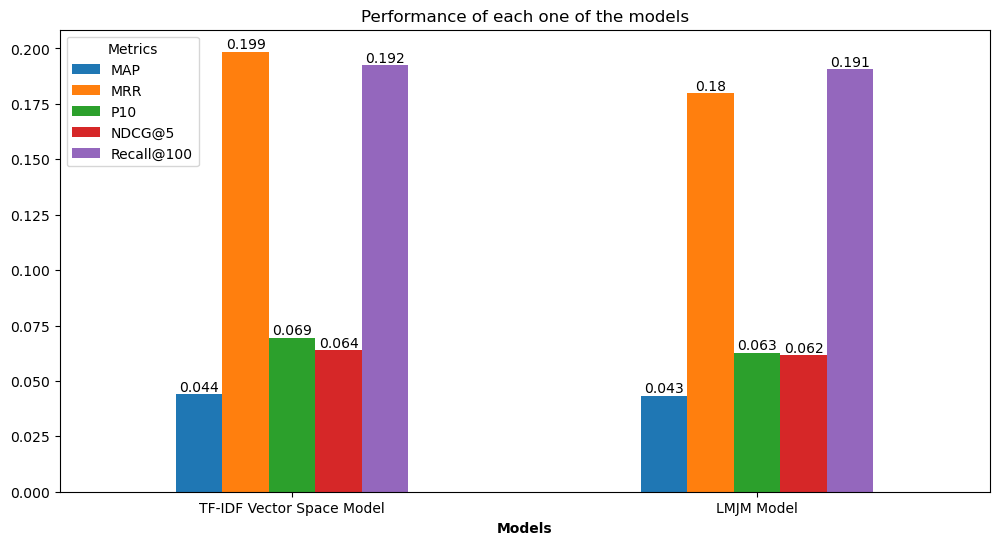

In [8]:
# charts
ax = metrics_summary.plot(
    kind='bar',
)

for cnt in ax.containers:
    ax.bar_label(cnt, labels=[f"{round(v, 3)}" for v in cnt.datavalues])

plt.xticks(rotation=0, horizontalalignment="center")
plt.xlabel('Models', fontweight='bold')
plt.title('Performance of each one of the models')
# plt.ylim(0, 0.5)
plt.legend(title='Metrics')
# plt.savefig('models-performance.pdf')
plt.show()


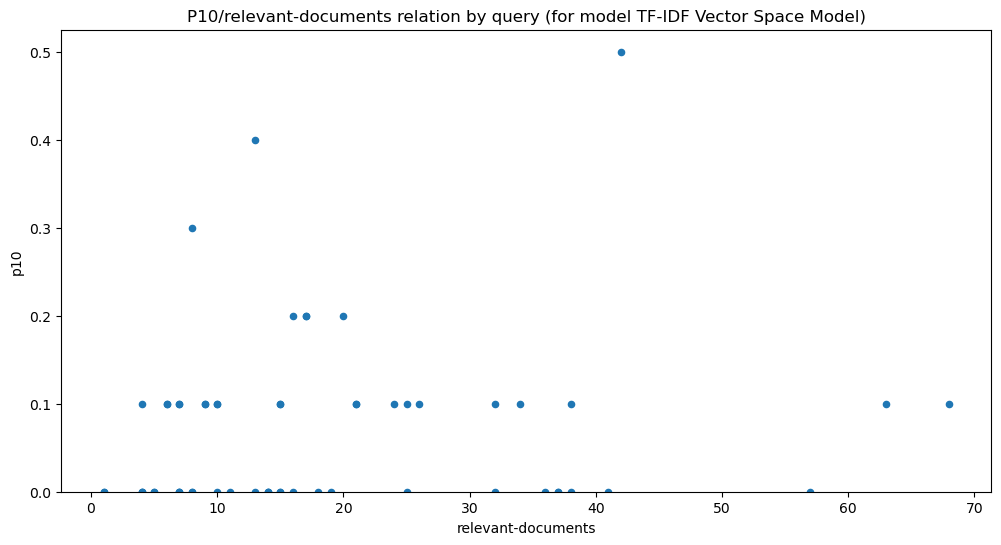

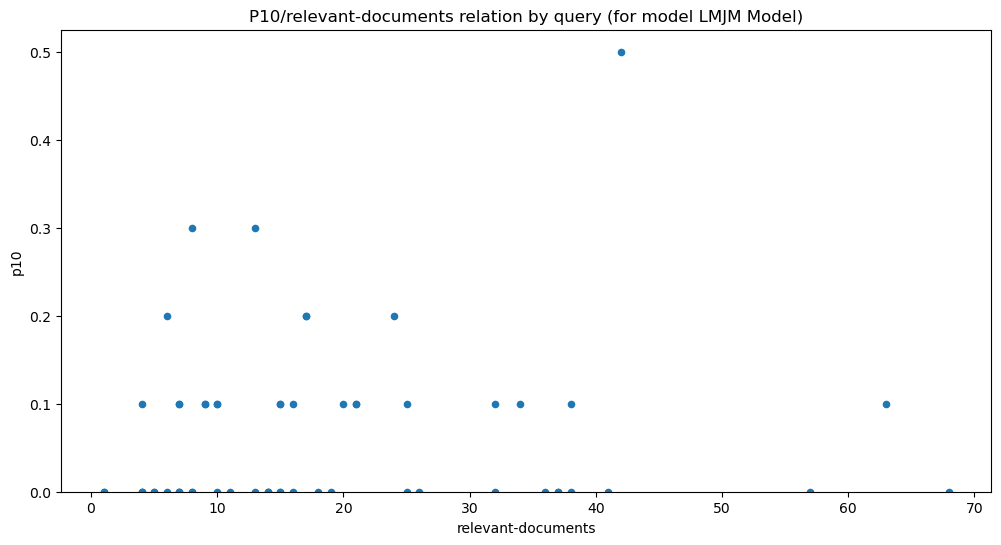

In [247]:
# p10/relevant documents charts 
for model_name, m in models_metrics.items(): m.plot_documents_precision(model_name)

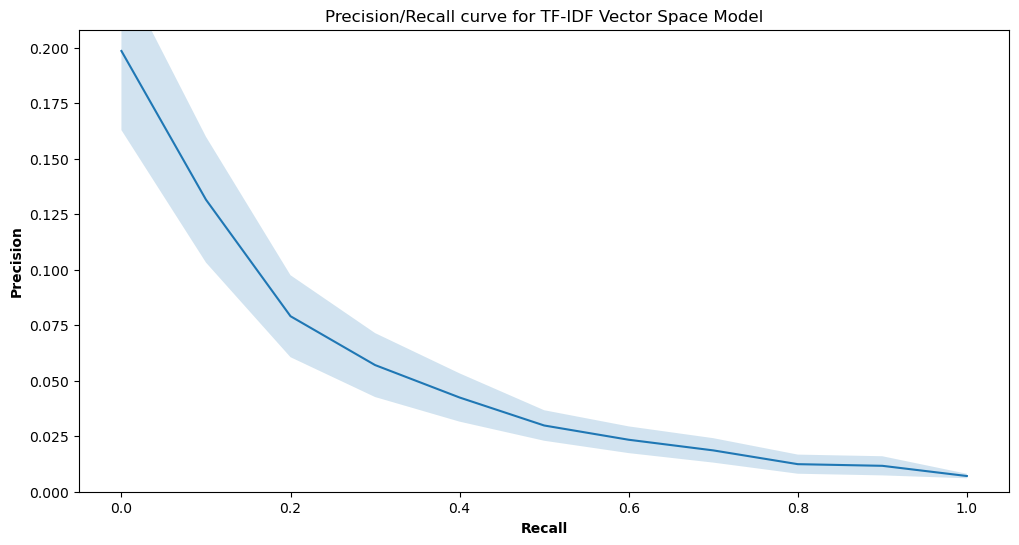

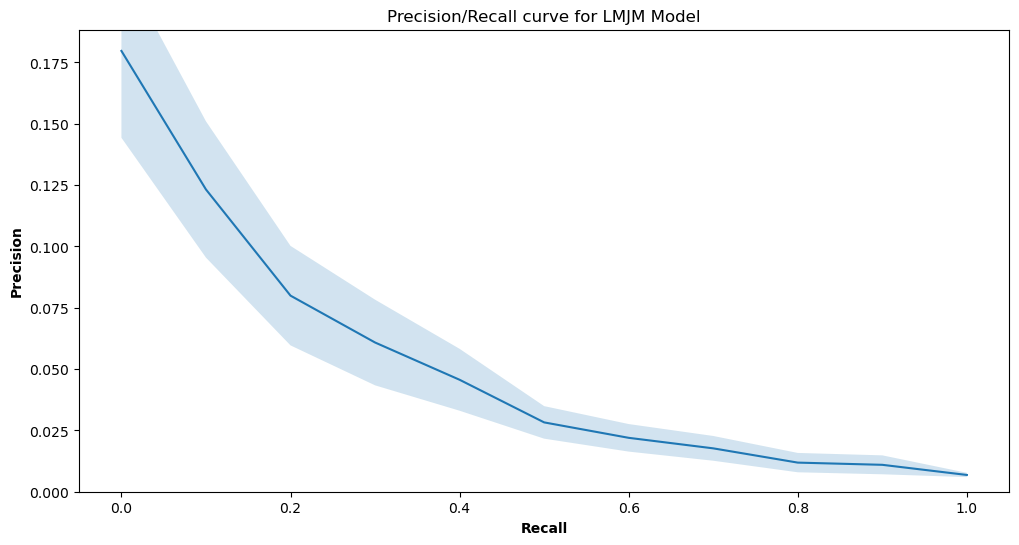

In [246]:
# precision recall curve
for name, m in models_metrics.items(): m.plot_precision_recall(name)

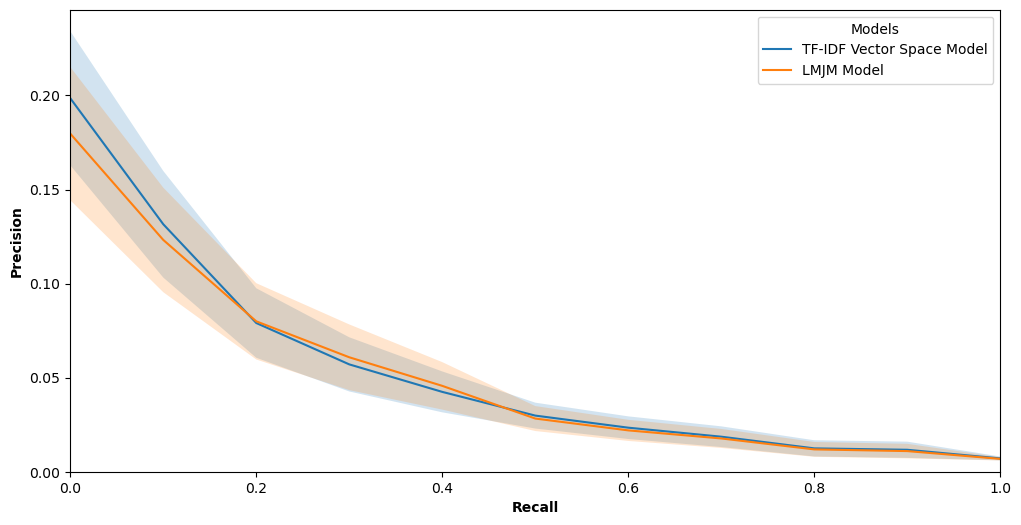

In [250]:
compare_pecision_recall_models(models_metrics) # plot the comparison of the models

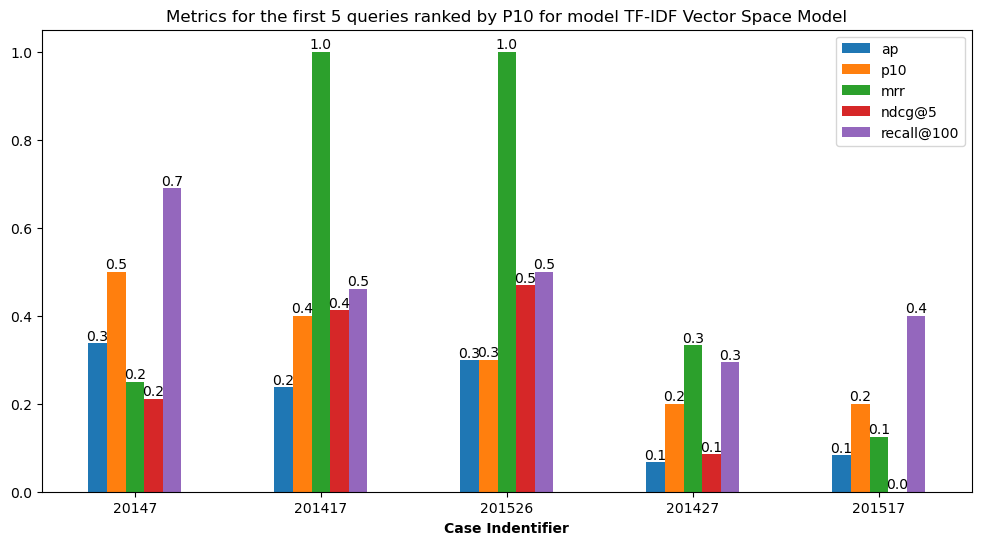

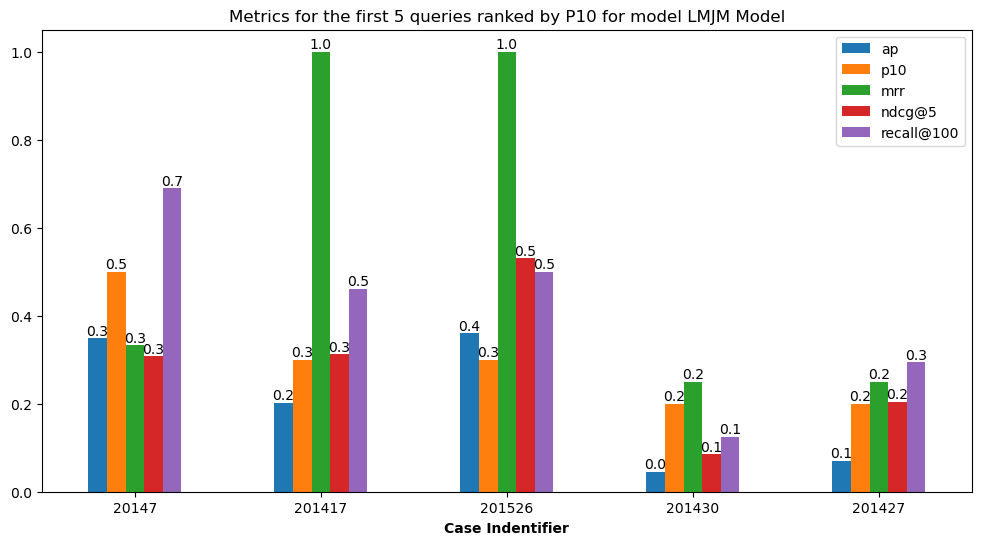

In [248]:
for name, m in models_metrics.items(): m.plot_top_5p10_metrics(name)

# 2nd Phase

## 1. Models

In [35]:
import pickle
import index
from os import path

CHOSEN_LAMBDA = 0.2

# queries that will be used :)
queries = long_cases
models  = ld.load(
    'initial-models',
    lambda: {
        # brief title
        'VSM (Brief Title)': index.VSMindex(corpus['bief_title']),
        'LMJM (Brief Title)': index.LMJMindex(corpus['bief_title'], _lambda=CHOSEN_LAMBDA),

        # brief summary
        'VSM (Brief Summary)': index.VSMindex(corpus['brief_summary']),
        'LMJM (Brief Summary)': index.LMJMindex(corpus['brief_summary'], _lambda=CHOSEN_LAMBDA),

        # detailed description
        'VSM (Detailed Description)': index.VSMindex(corpus['detailed_description']),
        'LMJM (Detailed Description)': index.LMJMindex(corpus['detailed_description'], _lambda=CHOSEN_LAMBDA),

        # criteria
        'VSM (Criteria)': index.VSMindex(corpus['criteria']),
        'LMJM (Criteria)': index.LMJMindex(corpus['criteria'], _lambda=CHOSEN_LAMBDA),
    }
)
# print(corpus['detailed_description'])

## 2. Performance of Individual Models (Fields)

In [36]:
# TODO: save this :)
# calculating metrics of each model

metrics = ld.load(
    'models-metrics', 
    lambda: dict([ (model_name, calc_metrics(model, queries))  for model_name, model in models.items() ] ),
)

metrics_summary = ld.load(
    'metrics-summary', 
    lambda: calc_metrics_summary(metrics),
)

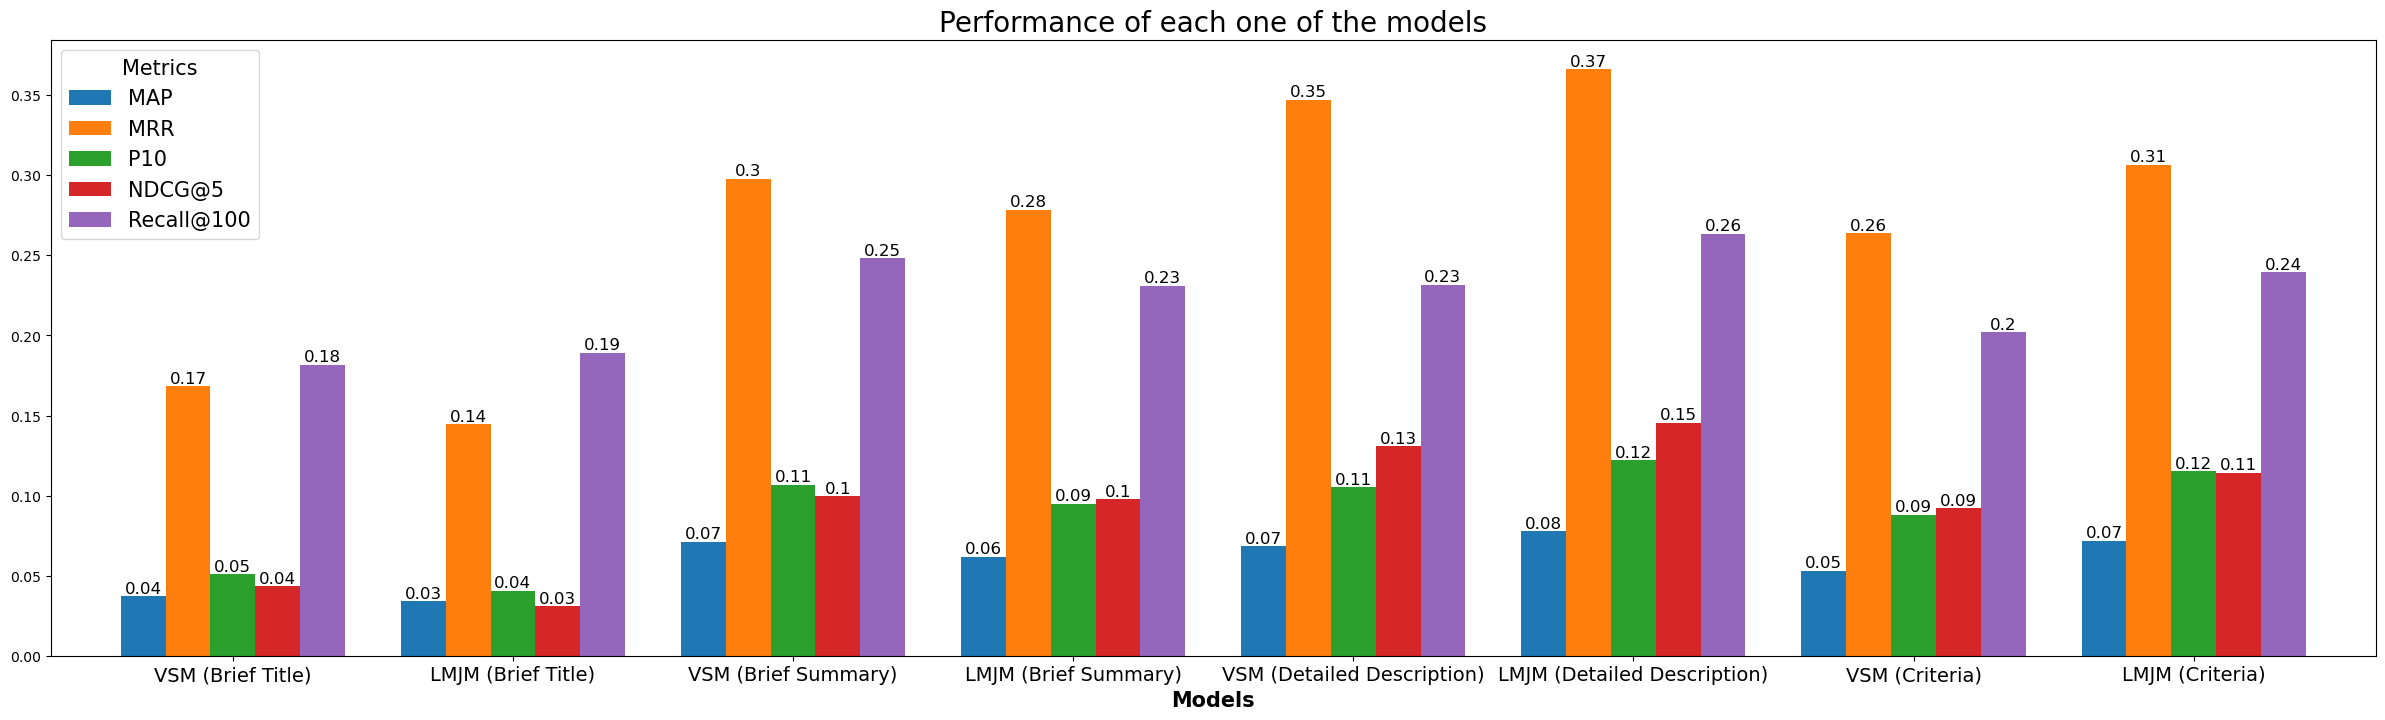

In [37]:
# plot the summay of the matrics across all the models
plot_summary_metrics(metrics_summary, filename='models-performance')

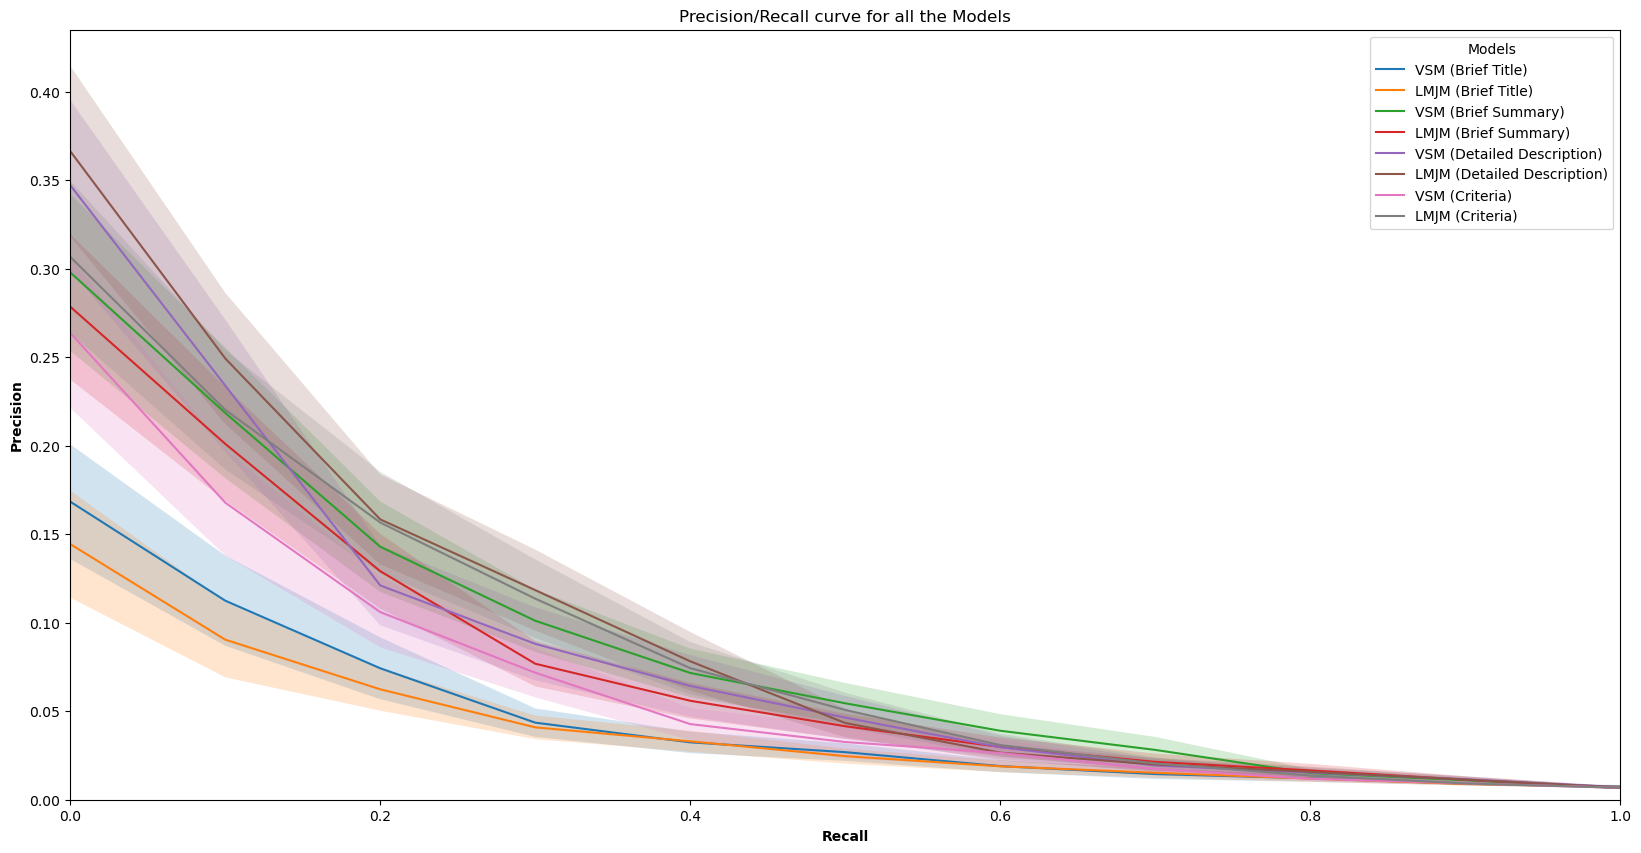

In [38]:
plt.rcParams['figure.figsize'] = [20, 10]
compare_pecision_recall_models(metrics, filename='precision-recall') # plot the comparison of the models

## 3. Training (LEITOR)

In [39]:
# generate scores for all models and queries
docs_scores = ld.load(
    'docs-scores',
    lambda: dict([
        (model_name, dict( 
            [ (caseid, calc_ranking(model, query, filter=False)) for caseid, query in long_cases.items()]) 
        ) for model_name, model in models.items()
    ])

)

In [40]:
pp.pprint(docs_scores['VSM (Brief Title)']['20141'])

              _id     score
2729  NCT02006251  0.264368
1740  NCT01243398  0.187830
636   NCT00400465  0.186139
2224  NCT01604655  0.183253
2875  NCT02100098  0.177233
...           ...       ...
3194  NCT02348541  0.000000
2096  NCT01514643  0.000000
1232  NCT00861133  0.000000
1225  NCT00857701  0.000000
2201  NCT01586520  0.000000

[3626 rows x 2 columns]


#### The queries and the best model (used to rank the queries and decide the test and train queries)

In [11]:
lmjm_full_text  = models['LMJM (Detailed Description)']
lmjm_scores     = docs_scores['LMJM (Detailed Description)']

#### Split the queries in train and test

In [41]:
def get_train_and_test_queires():
    queries_p10    = []

    for qid, qtxt in queries.items():
        order = calc_ranking(lmjm_full_text, qtxt)
        p10 = eval.eval(order, qid)[0]
        queries_p10.append((qid, p10))

    queries_p10.sort(key=lambda x: x[1])
    queries_idx = [x[0] for x in queries_p10]

    test_sep  = round( 1 / 0.25 )

    test_data  = queries_idx[::test_sep]
    train_data = [x for x in queries_idx if x not in test_data]

    return train_data, test_data

train_queries, test_queries = ld.load( 
    'test-and-train-queires',
    lambda: get_train_and_test_queires(),
)



train_queries_map = dict([ (qid, queries[qid]) for qid in train_queries ])
test_queries_map  = dict([ (qid, queries[qid]) for qid in test_queries ])


### 3.1 Generating (query, docs) input pairs

In [42]:
# helping functions
def get_query_doc_scores(query_id, doc_id):
    scores = []
    
    for model_score in docs_scores.values():
        df = model_score[query_id]
        score = df[df['_id'] == doc_id ]['score'].values[0]
        scores.append(score)
    
    return np.array(scores)

#### 3.1.1 Strategy 1 ( Judged Only )

In [43]:
# generate the inputs out of the queries
def gen_pairs_strategy_1(queries_ids):
    xx = []
    yy = []

    juddments = eval.relevance_judgments
    for quid in queries_ids:
        docs_rel = juddments[ 
            juddments['query_id'] == quid 
        ][['docid', 'rel']].itertuples(index=False)

        for docid, rel in docs_rel:
            xx.append(get_query_doc_scores(quid, docid))
            yy.append(rel)

    return (xx, yy)

# pp.pprint(train_queries)
# pp.pprint(test_queries)

x1_train, y1_train = ld.load(
    'train-data-st1',
    lambda: gen_pairs_strategy_1(train_queries), 
)

# This would be used to caculate the precision of the model (but now one cares c:)
x1_test, y1_test = ld.load(
    'test-data-st1',
    lambda: gen_pairs_strategy_1(test_queries),
)

#### 3.1.2 Strategy 2 (With non-judged documents)

In [44]:
def gen_pairs_strategy_2(queries_ids):
    xx = []
    yy = []

    juddments = eval.relevance_judgments
    for quid in queries_ids:
        docs_rel = juddments[ 
            juddments['query_id'] == quid 
        ]

        scored = set( docs_rel['docid'].values )
        for docid in ids:

            rel = 0
            if docid in scored:
                rel = docs_rel[docs_rel['docid'] == docid]['rel'].values[0]

            xx.append( get_query_doc_scores(quid, docid) )
            yy.append( rel  )

    return xx, yy

x2_train, y2_train = ld.load(
    'train-data-st2',
    lambda: gen_pairs_strategy_2(train_queries),
)

x2_test, y2_test = ld.load(
    'test-data-st2',
    lambda: gen_pairs_strategy_2(test_queries),
)

#### 3.1.3 Hard Negatives

In [45]:
def gen_pairs_strategy_3(queries_ids):
    xx = []
    yy = []

    juddments = eval.relevance_judgments
    for quid in queries_ids:
        docs_rel = juddments[ 
            juddments['query_id'] == quid
        ]

        scored = set( docs_rel['docid'].values )

        rank = lmjm_scores[quid]
        top  = rank.head( 100 )

        for docid in top['_id'].values:
            if not docid in scored:
                xx.append( get_query_doc_scores(quid, docid) )
                yy.append( 0 )

    xx_1, yy_1 = gen_pairs_strategy_1(queries_ids)
    return xx + xx_1 , yy + yy_1


x3_train, y3_train = ld.load(
    'train-data-st3',
    lambda: gen_pairs_strategy_3(train_queries),
)

x3_test, y3_test = ld.load(
    'test-data-st3',
    lambda: gen_pairs_strategy_3(test_queries),
)

### 3.2 LETOR Models

In [57]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import Tuple

from index import LETORindex

def reduce_rels(ys):
    return list(map(lambda y : int(y > 0), ys))

def train_logist_reg_model(x_train, y_train, sample_weight=None, **lr_parms) -> Tuple[LogisticRegression, StandardScaler]:

    # turn all the non-zero values to 1 (BY NOW)
    # y_train = reduce_rels(y_train)

    ss = StandardScaler()
    x_train = ss.fit_transform(x_train)

    clf = LogisticRegression(
        random_state=0,
        C=0.5,
        **lr_parms
    ).fit(x_train, y_train, sample_weight=sample_weight)

    return clf, ss

def build_letor_models( params ):
    return  dict(
        [ (name, LETORindex(models.values(), coefs, ss)) for name, (coefs, ss) in params.items() ]
    )

#### 3.2.1 LETOR for for the different Strategies

In [47]:
# todo: think abou this :)
from index import *
# from sklearn.metrics import classification_report


# :)
stratagies_compare = [
    ('Strategy 1 ( Judged Only )', x1_train, y1_train),
    ('Strategy 2 ( All )', x2_train, y2_train),
    ('Strategy 3 ( Hard Negatives )', x3_train, y3_train)
]

def calc_letor_strategy_params():

    model_coefs = {}
    for name, xx_train, yy_train in stratagies_compare:
        y_train = reduce_rels( yy_train )
        clf, ss = train_logist_reg_model(xx_train, y_train)
        model_coefs[name] = (clf.coef_.flatten(), ss)

    return model_coefs


letor_models = build_letor_models(
    ld.load(
        'letor-strategy-params',
        lambda: calc_letor_strategy_params()
    )

)

# ... :)
letor_metrics = ld.load(
    'letor-metrics-strategy-compare-metrics',
    lambda: dict( [ (name, calc_metrics(model, test_queries_map)) for name, model in letor_models.items() ] )
)

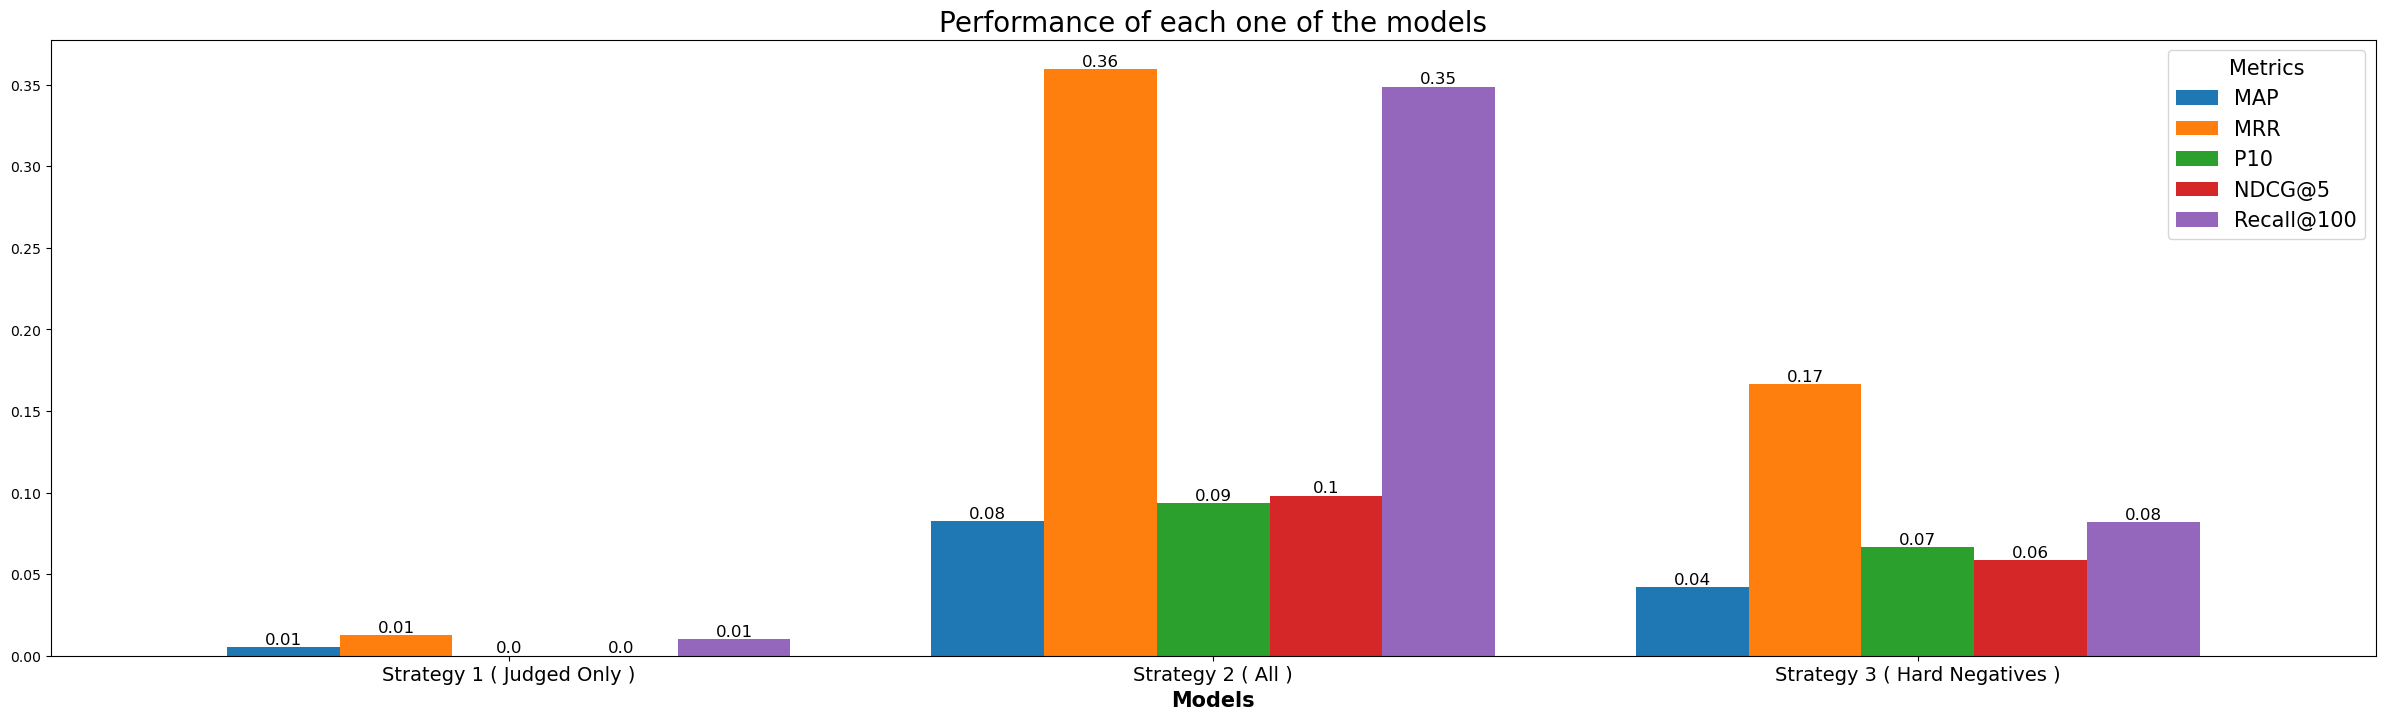

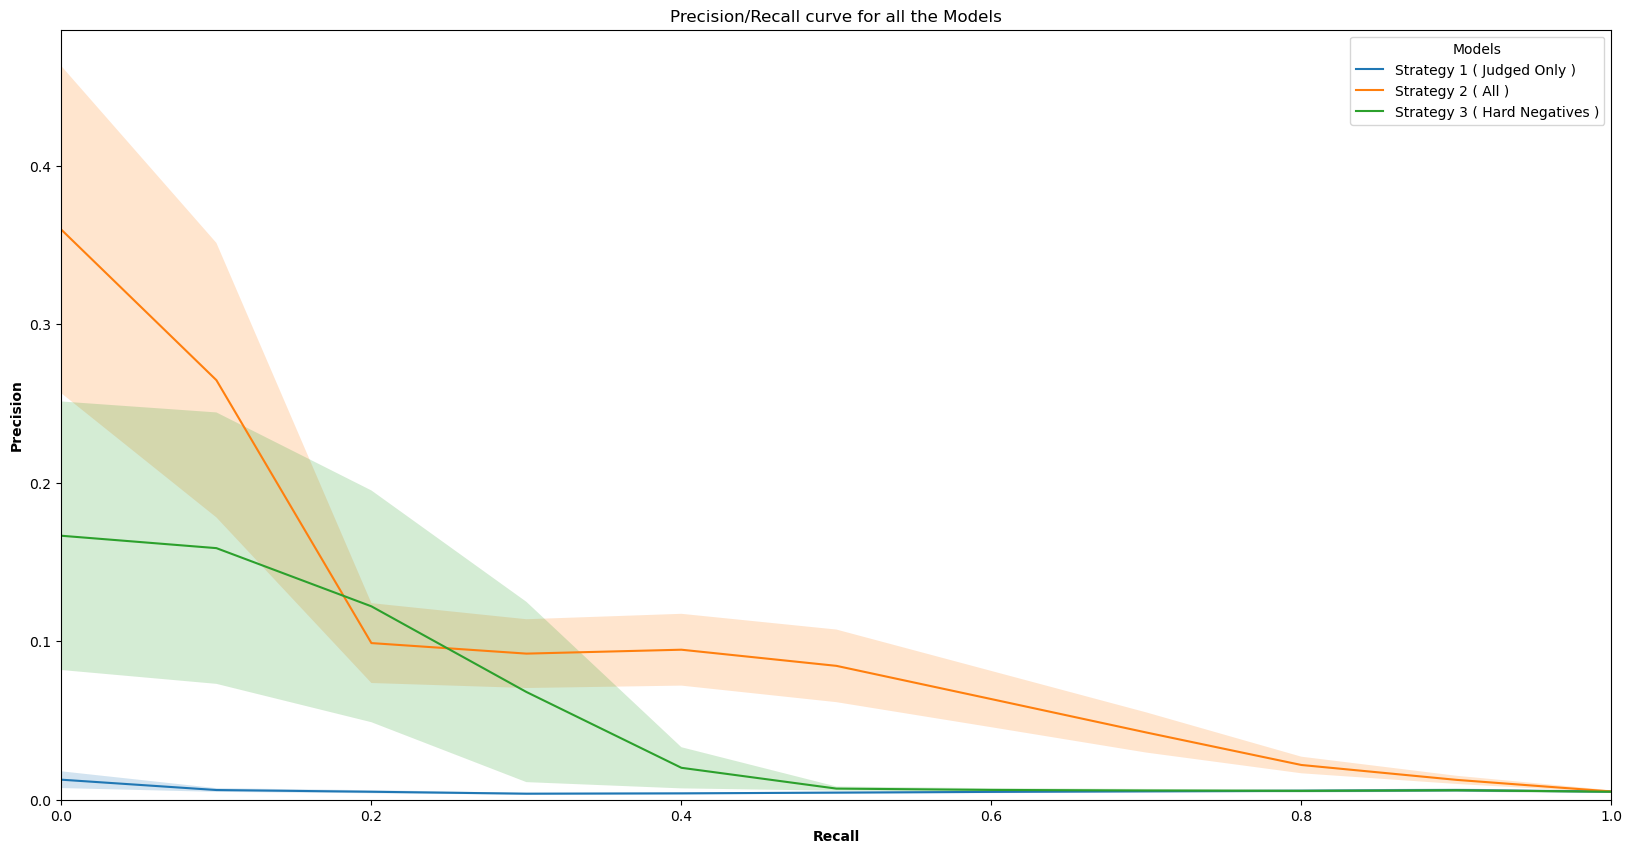

In [48]:
letor_metrics_summary = calc_metrics_summary(letor_metrics)
plot_summary_metrics(letor_metrics_summary, filename='letor-models-performance')
compare_pecision_recall_models(letor_metrics, filename='letor-precision-recall')

### 3.2.2 LECTOR for Imbalanced data correction

In [59]:
# Hard Negatives
x_train, y_train = x3_train, y3_train

def repeat_super_importants(x_train, y_train):
    super_important = list(filter(lambda v: v[1] > 1, enumerate(y_train)))

    x_res = x_train[:]
    y_res = y_train[:]

    for idx, _ in super_important:
        x_res.append(x_train[idx])
        y_res.append(y_train[idx])

    return x_res, y_res


def calc_lector_imbalance_params():
    yy_train = reduce_rels(y_train)
    clf_1, ss_1 = train_logist_reg_model(x_train, yy_train) 
    clf_2, ss_2 = train_logist_reg_model(x_train, yy_train, class_weight='balanced')

    xx, yy  = repeat_super_importants(x_train, y_train)
    clf_3, ss_3 = train_logist_reg_model(xx, reduce_rels(yy)) 

    # we have attributed the following weights:
    #   * 0 -> 0.1
    #   * 1 -> 0.3
    #   * 2 -> 0.6
    sample_weight = list(map(lambda y: 0.1 if y == 0 else 0.3 if y == 1 else 0.6, yy_train))
    clf_4, ss_4 = train_logist_reg_model(x_train, yy_train, sample_weight=sample_weight) 

    return {
        'Without any correction': (clf_1.coef_.flatten(), ss_1),
        'Balanced Weight': (clf_2.coef_.flatten(), ss_2),
        'Custom Weights': (clf_3.coef_.flatten(), ss_3),
        'Weight differently': (clf_4.coef_.flatten(), ss_4),
    }


imblamance_models = build_letor_models(
    ld.load(
        'letor-imblamance-params',
        lambda: calc_lector_imbalance_params()
    )
)

In [60]:
letor_imbalance_metrics = ld.load(
    'letor-imblamance-metrics',
    lambda: dict( [ (name, calc_metrics(model, test_queries_map)) for name, model in imblamance_models.items() ] )
)

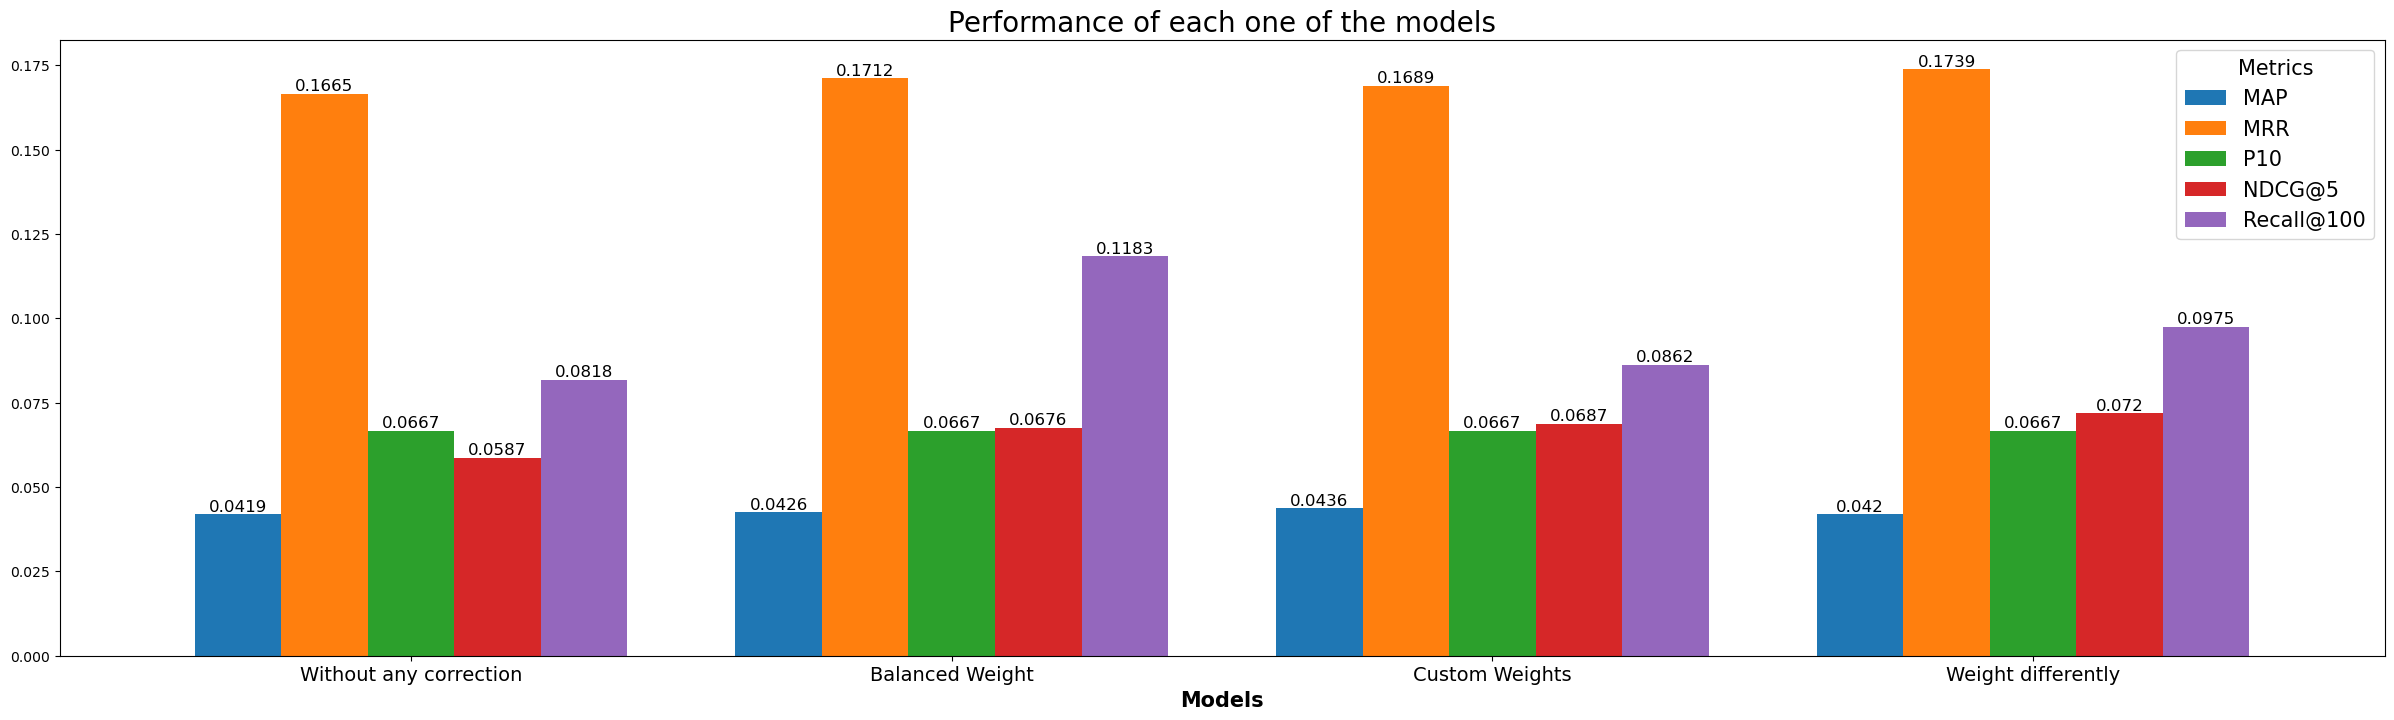

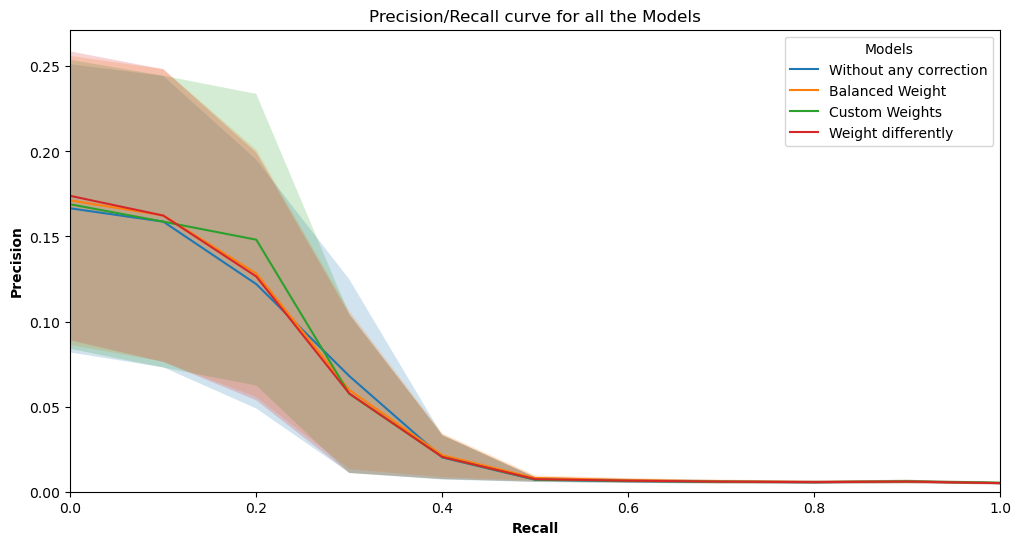

In [64]:
letor_imbalance_metrics_summary = calc_metrics_summary(letor_imbalance_metrics)
plot_summary_metrics(letor_imbalance_metrics_summary, decimal_case=4, filename='letor-imblamance-models-performance')
compare_pecision_recall_models(letor_imbalance_metrics, filename='letor-imblamance-precision-recall')

In [65]:
letor_imbalance_metrics_overall = ld.load(
    'letor-imblamance-metrics-overall',
    lambda: dict( [ (name, calc_metrics(model, queries)) for name, model in imblamance_models.items() ] )
)

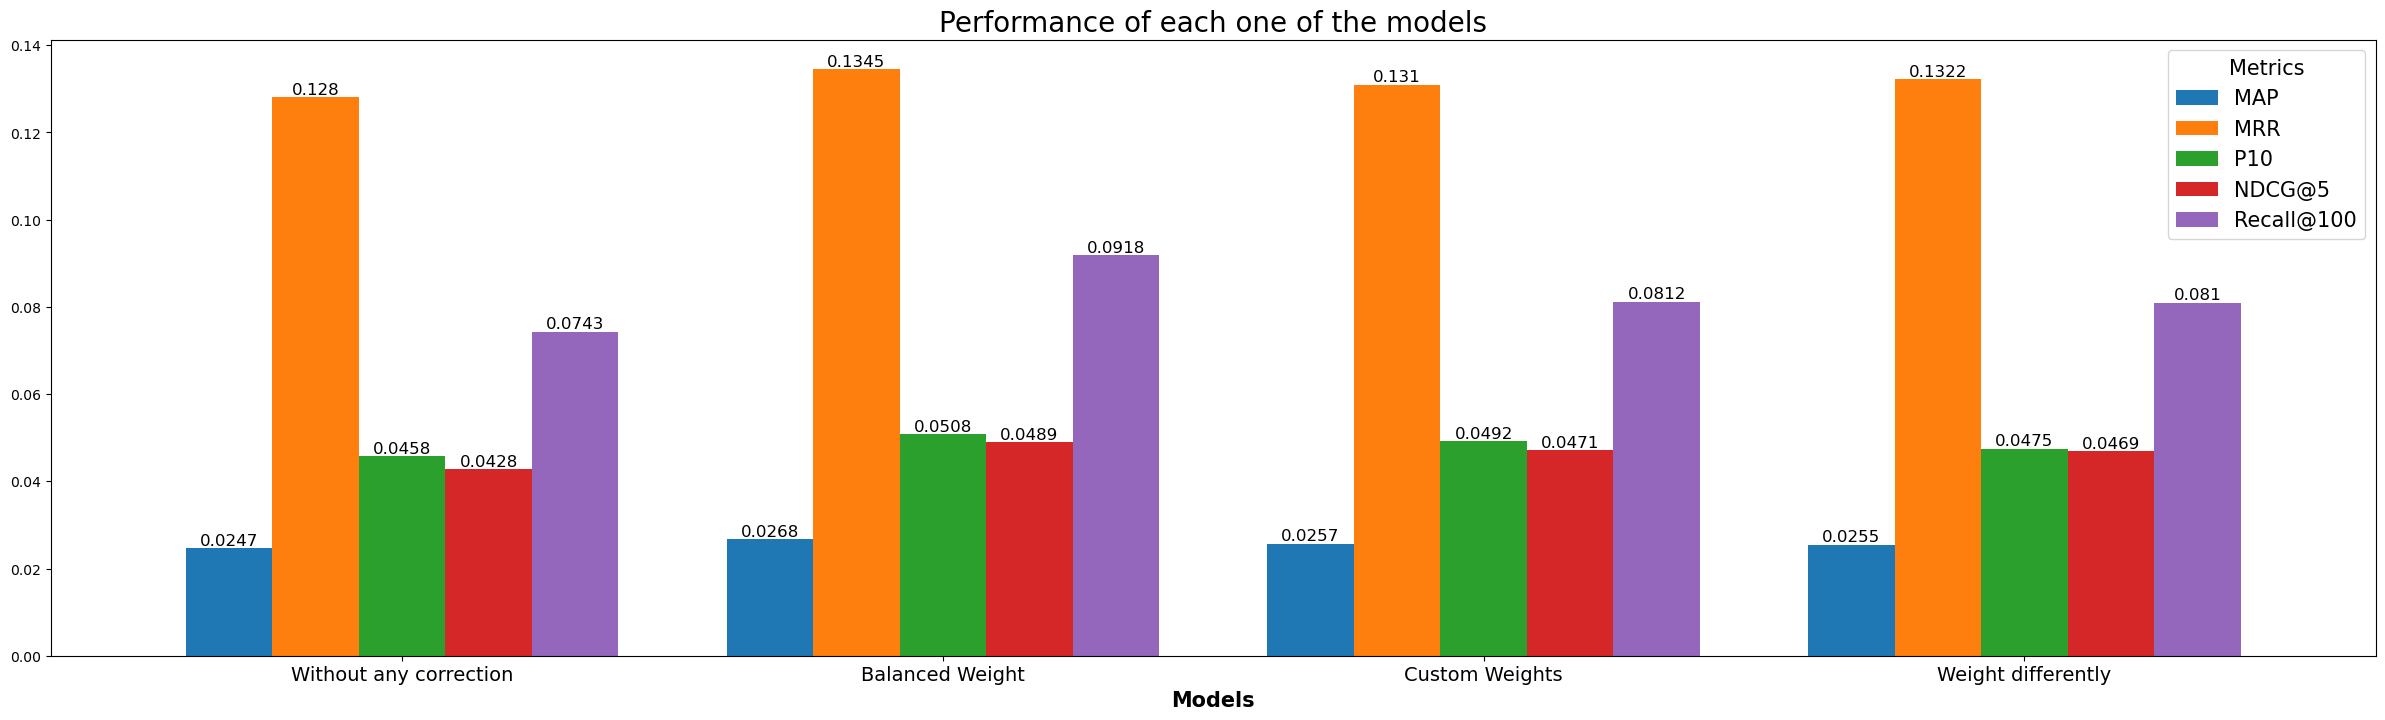

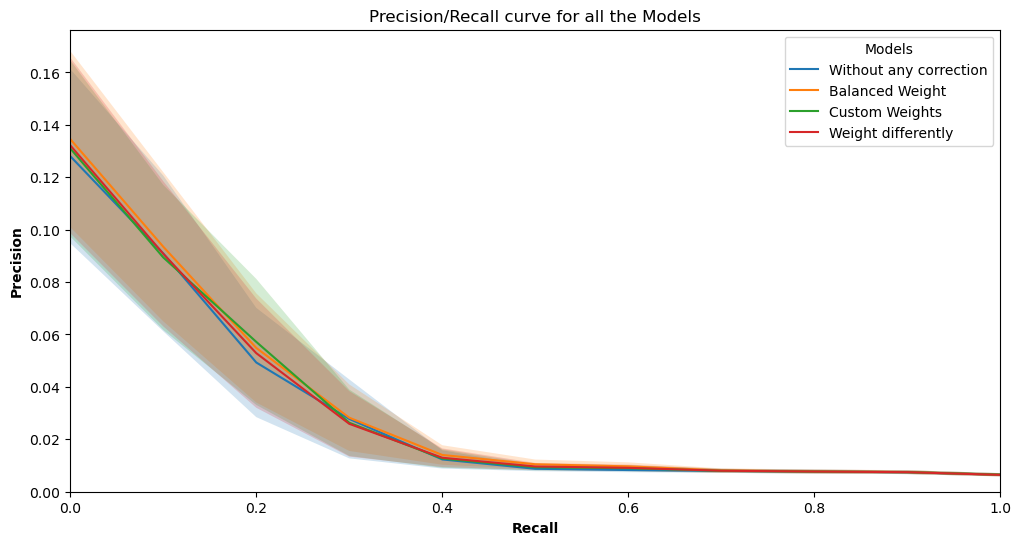

In [66]:
letor_metrics_summary_overall = calc_metrics_summary(letor_imbalance_metrics_overall)
plot_summary_metrics(letor_metrics_summary_overall, decimal_case=4, filename='letor-imblamance-models-performance-overall')
compare_pecision_recall_models(letor_imbalance_metrics_overall, filename='letor-imblamance-precision-recall-overall')

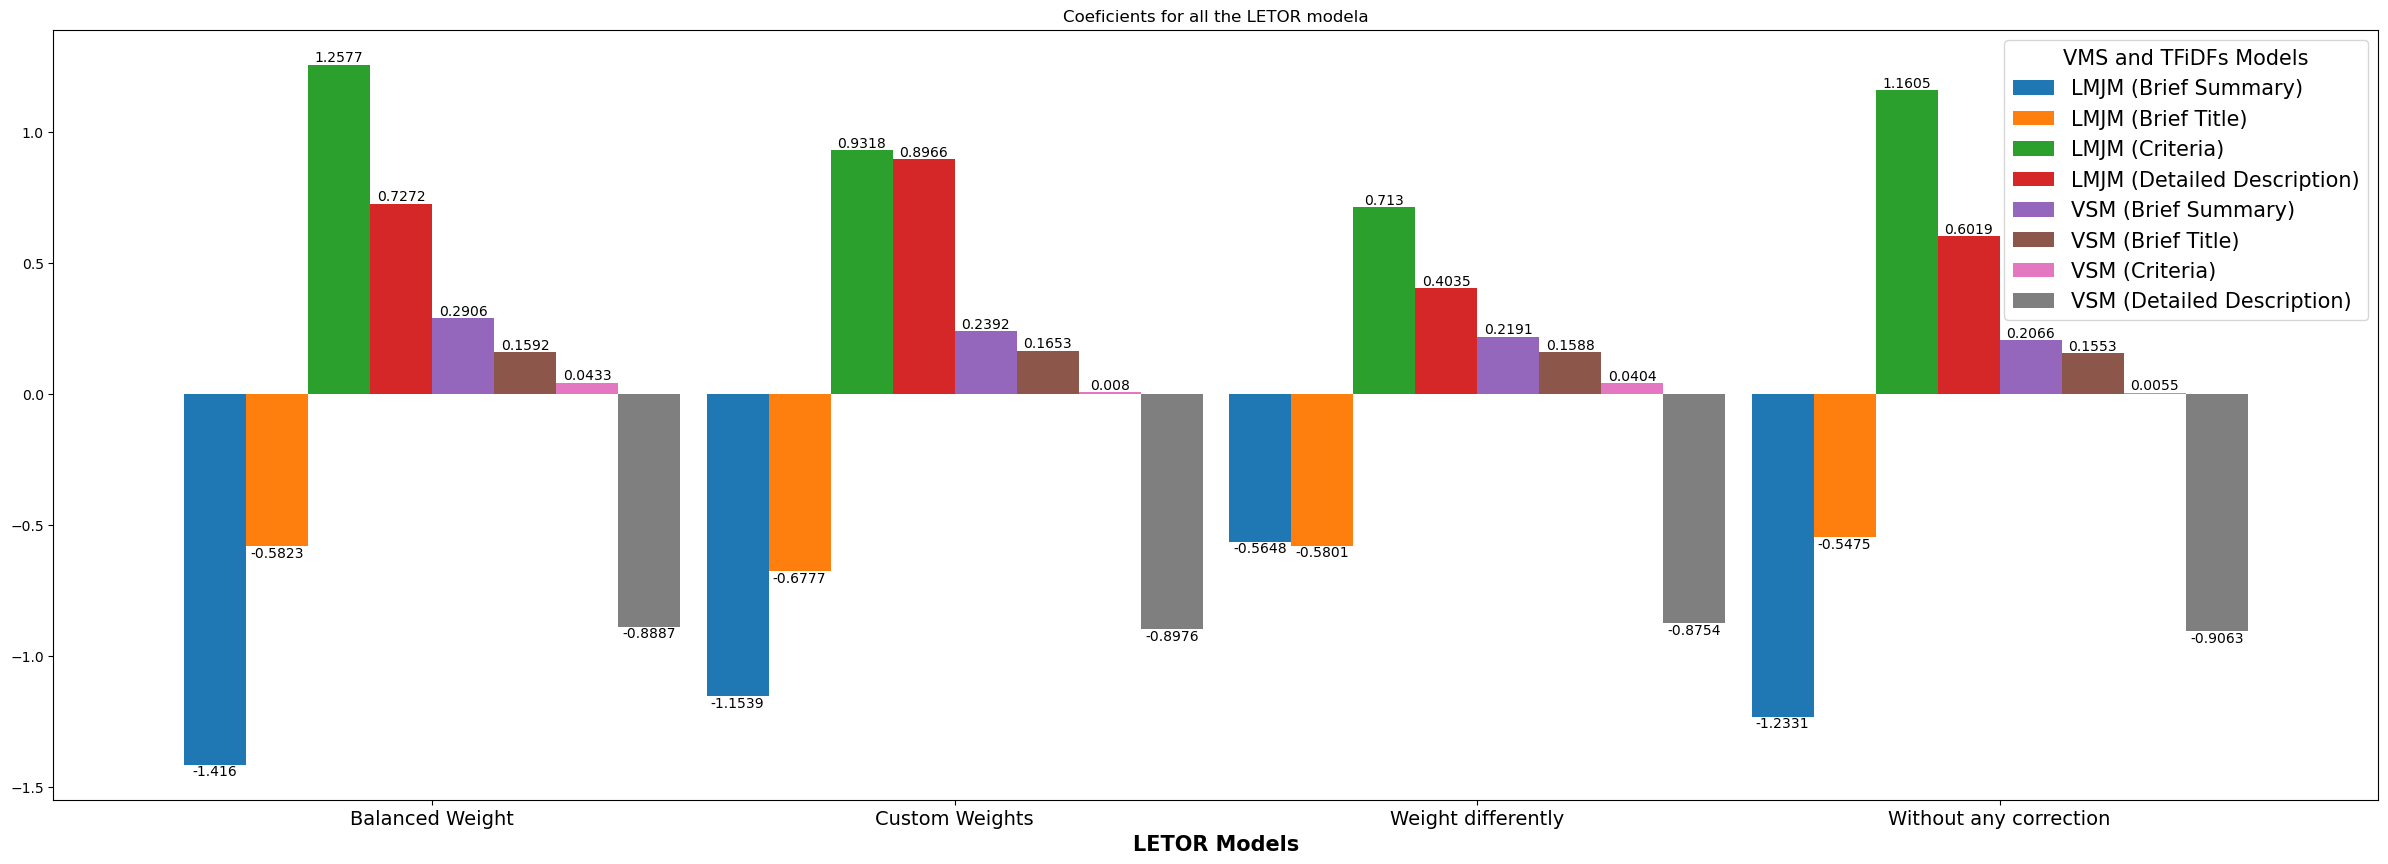

In [91]:
# ...
import pandas as pd



plt.rcParams['figure.figsize'] = [20, 10]

data = []
for letor_name, letor_model in imblamance_models.items():
    data.extend(
        [ ( letor_name, name , cf) for name, cf in zip(models.keys(), letor_model.coefs) ],
    )


df = pd.DataFrame(
    data,
    columns=['letor-model', 'model', 'coef']
).set_index('letor-model')


pivot_data = df.pivot(columns='model', values='coef')

ax = pivot_data.plot(
    kind='bar',
    title=f'Coeficients for all the LETOR modela',
    figsize=(30, 10),
    width=0.95,
)

for cnt in ax.containers:
    ax.bar_label(cnt, labels=[round(v, 4) for v in cnt.datavalues])

plt.legend(title='VMS and TFiDFs Models', fontsize=15, title_fontsize=15)
plt.xlabel('LETOR Models', fontweight='bold', fontdict={'fontsize': 15})
plt.xticks(rotation=0, horizontalalignment="center", fontsize=14)
plt.savefig('letor-models-coeficients.pdf')
plt.show()